In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer

from sklearn.model_selection import GridSearchCV

# Setting

In [ ]:
# path to where we our preprocessed data is
data_file_path = Path("../data")

# path to where we save our model results
model_results_file_path = Path("./model_results")

# target variable
TARGET_VAR = "price_per_dozen"

# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso()
}

# Hyperparameter grids
param_grids = {
    "Ridge Regression": {"alpha": [0.01, 0.1, 1, 10, 100]},
    "Lasso Regression": {"alpha": [0.001, 0.01, 0.1, 1, 10]}
}

# Load Dataset
dataset = pd.read_csv(f'{data_file_path}/merged_data.csv', index_col=0)

# --------- If we want to use Kfold (n = 5) -------- #
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# results = {}
# fold = 1

# for train_index, val_index in kf.split(X):
#     X_train, X_val = X.iloc[train_index], X.iloc[val_index]
#     y_train, y_val = Y.iloc[train_index], Y.iloc[val_index]

#     Model evaluation here

#     fold += 1

In [24]:
X = dataset[['disaster_cost_adjusted', 'human_outbreaks_per_million', 'covid_hospitalization_per_million', 'infected_flock_cnt', 'infected_h5n1_people_cnt', 'gas_price_per_gallon', 'temp_variance']].copy()
Y = dataset.loc[:, TARGET_VAR:TARGET_VAR] # Extract the target variable (Y)

X.head()

,disaster_cost_adjusted,human_outbreaks_per_million,covid_hospitalization_per_million,infected_flock_cnt,infected_h5n1_people_cnt,gas_price_per_gallon,temp_variance
0,0.000000,0.0,0.0,0.0,0.0,1.110,2.605921
1,0.000000,0.0,0.0,0.0,0.0,1.186,5.400545
2,0.000000,0.0,0.0,0.0,0.0,1.230,16.771467
3,7.919502,0.0,0.0,0.0,0.0,1.242,1.669675
4,0.000000,0.0,0.0,0.0,0.0,1.244,11.375845


# Regression

In [21]:
X = dataset[['disaster_cost_adjusted', 'human_outbreaks_per_million', 'covid_hospitalization_per_million', 'infected_flock_cnt', 'infected_h5n1_people_cnt', 'gas_price_per_gallon', 'temp_variance']].copy()
Y = dataset.loc[:, TARGET_VAR:TARGET_VAR] # Extract the target variable (Y)

# List to store all results
results_list = []
scoring = {
    "MSE": make_scorer(mean_squared_error, greater_is_better=False),
    "MAE": make_scorer(mean_absolute_error, greater_is_better=False),
    "R2": make_scorer(r2_score)
}

# Loop through models
for name, model in models.items():
    if name in param_grids:  # Apply GridSearchCV if hyperparameters exist
        grid_search = GridSearchCV(
            model, param_grids[name], 
            cv=5, scoring=scoring, refit="R2", n_jobs=None, verbose=True
        )
        grid_search.fit(X, Y)

        best_params = grid_search.best_params_
        best_model = grid_search.best_estimator_
    else:
        model.fit(X, Y)  # Train model directly if no hyperparameters
        best_params = "N/A"
        best_model = model

    # Predictions
    Y_pred = best_model.predict(X)

    # Calculate performance metrics
    mae = mean_absolute_error(Y, Y_pred)
    mse = mean_squared_error(Y, Y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(Y, Y_pred)

    # Store results
    results_list.append({
        'Model': name,
        'Best Params': best_params,
        'MAE': mae,
        'RMSE': rmse,
        'MSE': mse,
        'R2': r2
    })

# Convert results to a DataFrame
df_results = pd.DataFrame(results_list)
df_results.head()

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits


,Model,Best Params,MAE,RMSE,MSE,R2
0,Linear Regression,N/A,0.203715,0.343664,0.118105,0.715106
1,Ridge Regression,{'alpha': 10},0.203313,0.343785,0.118188,0.714905
2,Lasso Regression,{'alpha': 0.001},0.203654,0.343670,0.118109,0.715096


In [22]:
df_results.to_csv(f'{model_results_file_path}/linear_ridge_lasso_cv_result.csv')

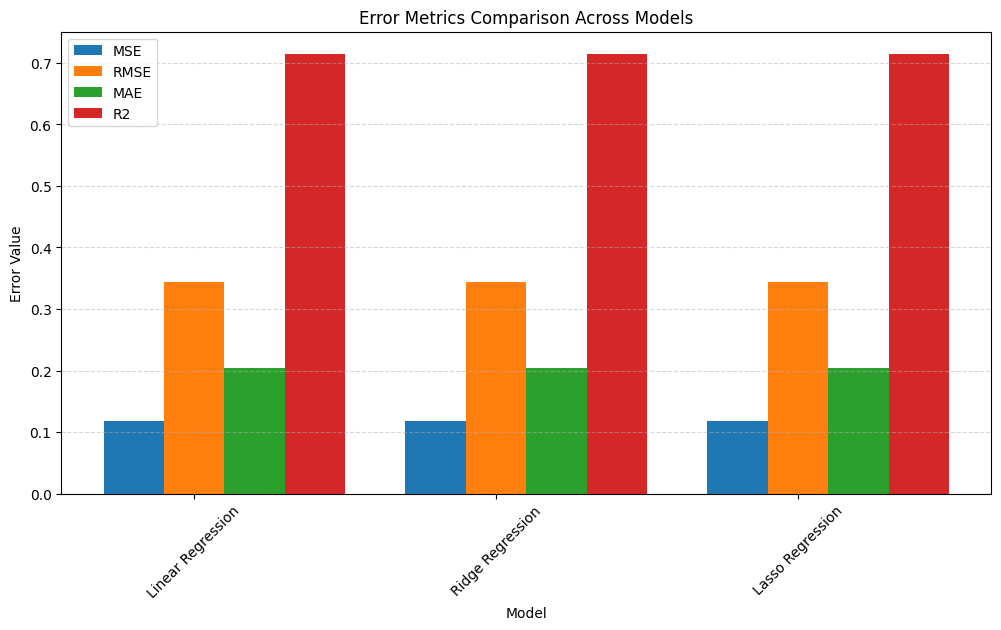

In [14]:
import numpy as np

metrics = ["MSE", "RMSE", "MAE", "R2"]
x = np.arange(len(df_results))  # X-axis positions for models

plt.figure(figsize=(12, 6))

for i, metric in enumerate(metrics):
    plt.bar(x + i * 0.2, df_results[metric], width=0.2, label=metric)

plt.xlabel("Model")
plt.ylabel("Error Value")
plt.title("Error Metrics Comparison Across Models")
plt.xticks(x + 0.2, df_results["Model"], rotation=45)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()